# Érmefelismerés beadandó

A beadandónkat teljesen saját képanyaggal készítettük el, 50 darab érmekép készült minden egyes magyar érmefajtából. A beadandó során alkalmaztunk augmentációt a képanyag növelésére, hogy a később betanított hálónk robosztusabb legyen. A projektben TransferLearninget es VGG16-ot használtunk fel.

### Import

In [13]:
import os
import glob

import random
import copy
from typing import Tuple
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg16, VGG16_Weights
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")


Device: cpu


### Adatok

Mivel a képanyagot szerettük volna elérhetővé tenni, GitHubban hoztunk létre egy Public repository-t, ahol a coins mappában található meg a 300 kép (50-50 darab 5-ös, 10-es, 20-as, 50-es, 100-as illetve 200-as). Ahhoz, hogy a GitHub-ba a feltöltés lehetséges legyen, először le kellett csökkentenünk a képfájlok méretét, ezután sikerült feltölteni, majd colab-ban a megfelelő parancsokat felhasználva behívni, hogy később tanítani lehessen vele a modellünket.

In [14]:
!git clone https://github.com/Borkalion/minta-kep-beadando.git

Cloning into 'minta-kep-beadando'...
remote: Enumerating objects: 331, done.
remote: Counting objects: 100% (331/331), done.
remote: Compressing objects: 100% (327/327), done.
remote: Total 331 (delta 10), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (331/331), 41.70 MiB | 11.67 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [15]:
%cd minta-kep-beadando

/content/minta-kep-beadando/minta-kep-beadando/minta-kep-beadando


In [16]:
COINS = 'coins'
class_names = ['5', '10', '20', '50', '100', '200']
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

image_paths = sorted(glob.glob(os.path.join(COINS, '*.jpg')))
if not image_paths:
    raise FileNotFoundError(f"Nem található kép a {TRIAL} mappában.")

records = []
for path in image_paths:
    base = os.path.basename(path)
    label_name = base.split('_')[0]
    if label_name not in class_to_idx:
        raise ValueError(f"Ismeretlen címke a fájlnévből: {base}")
    records.append({
        'path': path,
        'label_name': label_name,
        'label_idx': class_to_idx[label_name],
    })

    df = pd.DataFrame(records)


### Példák a beolvasott érmeképekre

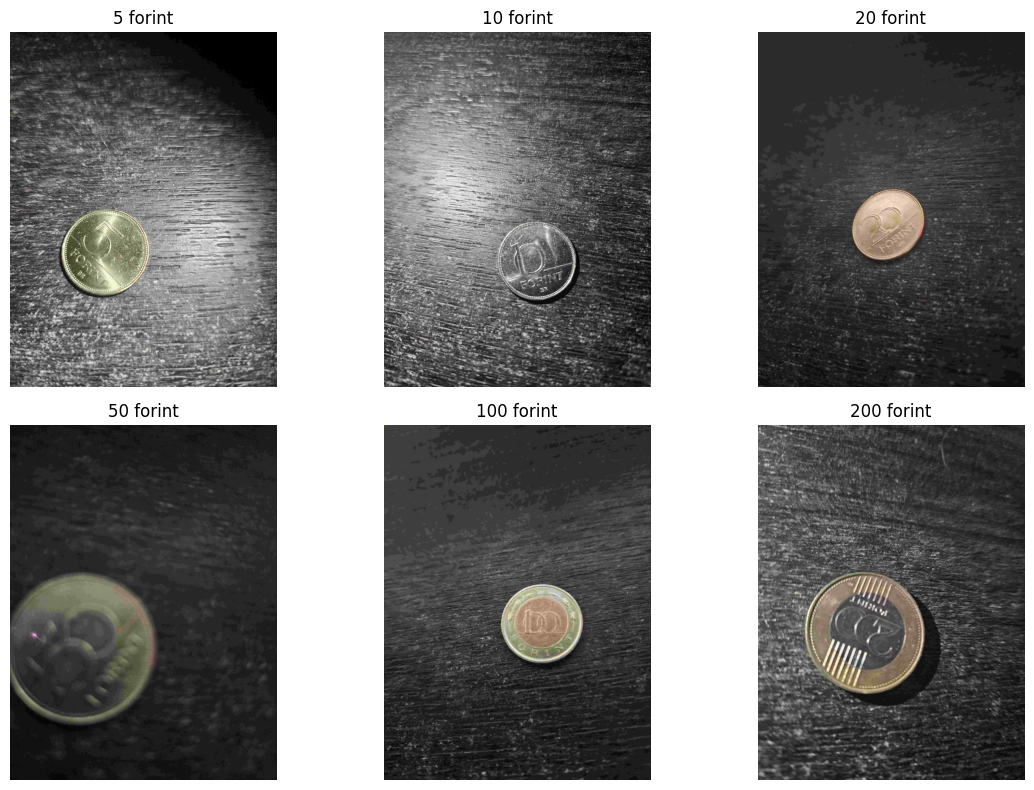

In [17]:
image = "coins"
coin_types = ["5", "10", "20", "50", "100", "200"]

plt.figure(figsize=(12, 8))

for i, coin in enumerate(coin_types, 1):
    pattern = os.path.join(image, f"{coin}_forint_*.jpg")
    files = glob.glob(pattern)

    img_path = files[0]
    img = Image.open(img_path)

    plt.subplot(2, 3, i)
    plt.imshow(img)
    plt.title(f"{coin} forint")
    plt.axis("off")

plt.tight_layout()
plt.show()


### Train-Val-Test Split



A train-val-test arány végül 70-15-15 lett, két főbb szempontot figyelembe véve: a train adathalmaznak elég nagynak kellett lenni, míg a validációnak és a tesztnek valóban reprezentálnia kellett az osztályokat. Mivel 50 képünk volt érménként, nem volt érdemes túl nagy tesztkészletet kialakítani, hiszen nem maradt volna elegendő a tanításkor, főleg finomhangolásra.

In [18]:
df_train, df_plus = train_test_split(df, test_size=0.30, stratify=df['label_idx'], random_state=SEED)
df_val, df_test = train_test_split(df_plus, test_size=0.50, stratify=df_plus['label_idx'], random_state=SEED)

In [19]:
def print_split_stats(df_train, df_val, df_test, label_col='label_idx', class_names=None):
    print("TRAIN-VAL-TEST MÉRET ÉS ARÁNYOK")
    print(f"Train méret: {len(df_train)}")
    print(f"Val méret:   {len(df_val)}")
    print(f"Test méret:  {len(df_test)}\n")

    total = len(df_train) + len(df_val) + len(df_test)
    print(f"Train: {len(df_train)/total*100:.2f}%")
    print(f"Val:   {len(df_val)/total*100:.2f}%")
    print(f"Test:  {len(df_test)/total*100:.2f}%\n")

    print("TRAIN-VAL-TEST ELOSZLÁS")

    def print_class_dist(df, name):
        print(f"\n {name} ")
        counts = df[label_col].value_counts().sort_index()
        for idx, count in counts.items():
            cname = class_names[idx] if class_names else idx
            print(f"  {cname}: {count} db ({count/len(df)*100:.1f}%)")

    print_class_dist(df_train, "TRAIN-")
    print_class_dist(df_val, "VAL-")
    print_class_dist(df_test, "TEST-")

print_split_stats(df_train, df_val, df_test, label_col='label_idx', class_names=class_names)


TRAIN-VAL-TEST MÉRET ÉS ARÁNYOK
Train méret: 210
Val méret:   45
Test méret:  45

Train: 70.00%
Val:   15.00%
Test:  15.00%

TRAIN-VAL-TEST ELOSZLÁS

 TRAIN- 
  5: 35 db (16.7%)
  10: 35 db (16.7%)
  20: 35 db (16.7%)
  50: 35 db (16.7%)
  100: 35 db (16.7%)
  200: 35 db (16.7%)

 VAL- 
  5: 8 db (17.8%)
  10: 8 db (17.8%)
  20: 7 db (15.6%)
  50: 7 db (15.6%)
  100: 7 db (15.6%)
  200: 8 db (17.8%)

 TEST- 
  5: 7 db (15.6%)
  10: 7 db (15.6%)
  20: 8 db (17.8%)
  50: 8 db (17.8%)
  100: 8 db (17.8%)
  200: 7 db (15.6%)


### Augmentációk

A következő cella kimenetele megmutatja, hogy jelenleg a képek 3000x4000-es felbontásúak, míg a VGG16 csak 224x224-eset használ. Ezzel mentünk tovább és segítségül hívtuk az Imagenet normalizálási lehetőségét.

In [20]:
img = Image.open(glob.glob("coins/*.jpg")[0])
print(img.size)

(3000, 4000)


A következő augmentációkat hajtottuk végre:

Train halmazon

1.   RandomResizedCrop - különböző méretű és pozíciójú kivágások
2.   RandomRotation - érméknél nincsen nagyon "irány", de 45 fokot már soknak ítéltünk
3.   RandomHorizontalFlip - mivel mindig szimmetrikusak maradnak az érmék így okés
4.   ColorJitter - fényviszony augmentáció
5.   RandomApply - enyhe zaj/homály használata

Val halmazon

Csak olyan lépések alkalmazása amelyek nem torzítják a képet


In [21]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

val_test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])


### Dataset + Dataloader

In [22]:
class CoinDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int, str]:
        row = self.df.iloc[idx]
        image = Image.open(row['path']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = int(row['label_idx'])
        return image, label, row['path']

train_dataset = CoinDataset(df_train, transform=train_transform)
val_dataset = CoinDataset(df_val, transform=val_test_transform)
test_dataset = CoinDataset(df_test, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### VGG16 utolsó simítás

Utolsó simításként betöltöttük az ImageNeten előtanított VGG16 modellt, befagyasztottuk a konvolúciós rétegeit, majd lecseréltük a végső osztályozós rétegét a saját érméink osztályaira.

In [23]:
model = torchvision.models.vgg16(weights="IMAGENET1K_V1")

for param in model.features.parameters():
    param.requires_grad = False

model.classifier[6] = nn.Linear(4096, len(class_names))

model = model.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 77.6MB/s]


### VGG16 modell létrehozása

A következőkben egy VGG16 modellt hoztunk létre, amely először csak 8 epochon keresztül csak a kicserélt classifier fejét tanítja 3e-4-es learning rate-tel, majd finomhangoláskor feloldottuk a konvolúciós rétegek 17-es index utáni részét, majd további 15 epochig tanítottuk 3e-5-ös learning rate-tel, miközben 1e-4-es weight decay-t alkalmaztunk amire e ReduceROnPlateau ütemezőt helyeztük rá, hogy szabályozza a tanulási rátát.

In [24]:
class Config:
    head_lr = 3e-4
    finetune_lr = 3e-5
    weight_decay = 1e-4

    stage1_epochs = 8
    stage2_epochs = 15

    unfreeze_start_idx = 17
    scheduler_factor = 0.3
    scheduler_patience = 3

cfg = Config()

def create_vgg16(num_classes):
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

    # Backbone fagyasztása (features blokkok)
    for p in model.features.parameters():
        p.requires_grad = False

    # Utolsó classifier réteg cseréje
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, num_classes)

    return model.to(device)

def trainable_params(model):
    return (p for p in model.parameters() if p.requires_grad)

def create_optimizer(lr, model):
    return optim.Adam(
        trainable_params(model),
        lr=lr,
        weight_decay=cfg.weight_decay
    )


def create_scheduler(optimizer):
    return optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=cfg.scheduler_factor,
        patience=cfg.scheduler_patience
    )

def unfreeze_last_conv_block(model, start_idx):
    for name, p in model.features.named_parameters():
        layer_idx = int(name.split('.')[0])
        if layer_idx >= start_idx:
            p.requires_grad = True

num_classes = len(class_names)   # pl. 6 érmeosztály

model = create_vgg16(num_classes)

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
criterion = nn.CrossEntropyLoss()
optimizer = create_optimizer(cfg.head_lr, model)
scheduler = create_scheduler(optimizer)

print("Trainable param szám (head-only):",
      f"{sum(p.numel() for p in trainable_params(model)):,}")

Trainable param szám (head-only): 119,570,438


### Betanítási ciklus

In [25]:
# Epoch futtatás (train vagy val)

def run_epoch(dataloader, model, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels, _ in dataloader:
        images, labels = images.to(device), labels.to(device)

        if is_train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(is_train):
            outputs = model(images)
            loss = criterion(outputs, labels)
            preds = outputs.argmax(dim=1)

            if is_train:
                loss.backward()
                optimizer.step()

        running_loss += loss.item() * images.size(0)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

# Teljes tanítás

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

best_val_acc = 0.0
best_state_path = "best_vgg16_coins.pth"
best_wts = None

total_epochs = cfg.stage1_epochs + cfg.stage2_epochs

for epoch in range(1, total_epochs + 1):

    # Fine-tuning indul
    if epoch == cfg.stage1_epochs + 1:
        print("\n FINE-TUNING \n")
        unfreeze_last_conv_block(model, cfg.unfreeze_start_idx)
        optimizer = create_optimizer(cfg.finetune_lr, model)
        scheduler = create_scheduler(optimizer)

    # Train + Validation futtatás
    train_loss, train_acc = run_epoch(train_loader, model, criterion, optimizer)
    val_loss, val_acc = run_epoch(val_loader, model, criterion)

    # Scheduler update
    scheduler.step(val_loss)

    # History mentés (görbékhez)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    # Best modell mentése
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_wts = model.state_dict().copy()
        torch.save(best_wts, best_state_path)

    # LOG KIJELZÉS
    phase = "HEAD" if epoch <= cfg.stage1_epochs else "FINETUNE"
    lr = optimizer.param_groups[0]['lr']

    print(
        f"Epoch {epoch}/{total_epochs} [{phase}] | "
        f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f} | "
        f"LR: {lr:.6e}"
    )

print("\n Legjobb validation accuracy:", best_val_acc)


Epoch 1/23 [HEAD] | Train Loss: 1.7482, Acc: 0.2333 | Val Loss: 1.4546, Acc: 0.4000 | LR: 3.000000e-04
Epoch 2/23 [HEAD] | Train Loss: 1.3142, Acc: 0.4952 | Val Loss: 1.3417, Acc: 0.4444 | LR: 3.000000e-04
Epoch 3/23 [HEAD] | Train Loss: 1.1843, Acc: 0.5286 | Val Loss: 1.1529, Acc: 0.6000 | LR: 3.000000e-04
Epoch 4/23 [HEAD] | Train Loss: 1.0523, Acc: 0.6000 | Val Loss: 1.0131, Acc: 0.6444 | LR: 3.000000e-04
Epoch 5/23 [HEAD] | Train Loss: 0.8497, Acc: 0.6619 | Val Loss: 1.0983, Acc: 0.6222 | LR: 3.000000e-04
Epoch 6/23 [HEAD] | Train Loss: 0.6478, Acc: 0.7619 | Val Loss: 0.9819, Acc: 0.6444 | LR: 3.000000e-04
Epoch 7/23 [HEAD] | Train Loss: 0.6707, Acc: 0.7429 | Val Loss: 1.1123, Acc: 0.6222 | LR: 3.000000e-04
Epoch 8/23 [HEAD] | Train Loss: 0.4923, Acc: 0.8286 | Val Loss: 1.0414, Acc: 0.6667 | LR: 3.000000e-04

 FINE-TUNING 

Epoch 9/23 [FINETUNE] | Train Loss: 0.4876, Acc: 0.8143 | Val Loss: 0.8567, Acc: 0.7111 | LR: 3.000000e-05
Epoch 10/23 [FINETUNE] | Train Loss: 0.3731, Acc: 0.8

### Kiértékelések

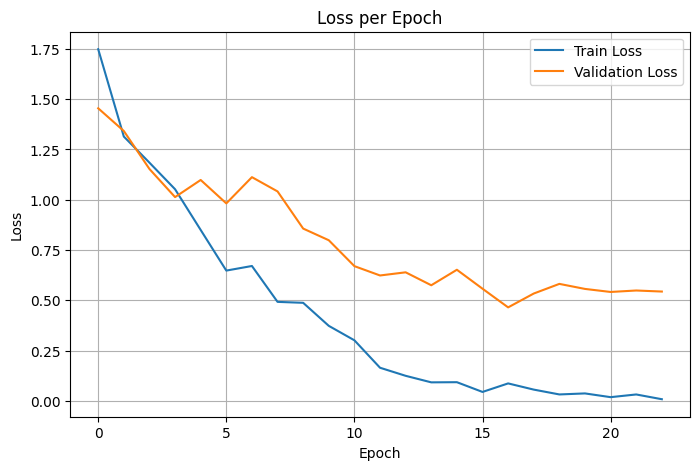

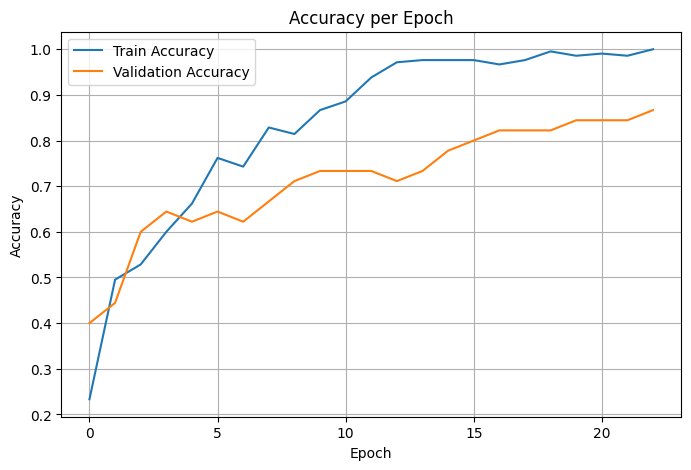

In [26]:
# LOSS ACC GÖRBÉK

import matplotlib.pyplot as plt

# Loss görbe
plt.figure(figsize=(8, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy görbe
plt.figure(figsize=(8, 5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# TEST LOSS ÉS ACCURACY

model.eval()
test_running_loss = 0.0
test_correct = 0
test_total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels, _ in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        preds = outputs.argmax(dim=1)

        test_running_loss += loss.item() * images.size(0)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss = test_running_loss / test_total
test_acc = test_correct / test_total

print(f"\n TEST RESULTS")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_acc:.4f}\n")


 TEST RESULTS
Loss: 0.3512
Accuracy: 0.9333



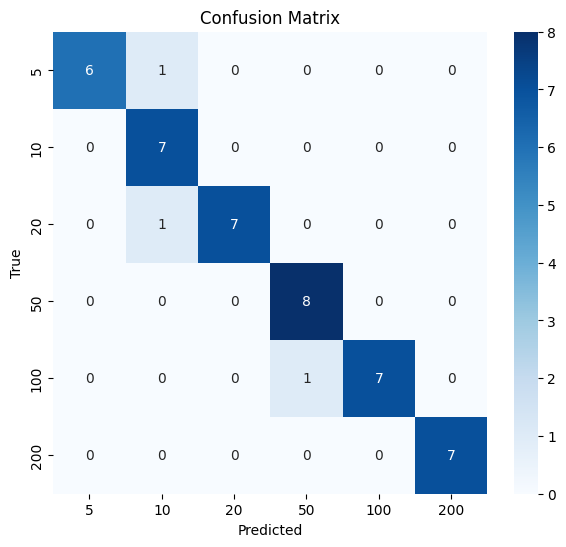

In [28]:
# CONFUSION MATRIX

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [29]:
# CLASSIFICATION REPORT

print("\n CLASSIFICATION REPORT")
print(classification_report(all_labels, all_preds, target_names=class_names))

plt.show()


 CLASSIFICATION REPORT
              precision    recall  f1-score   support

           5       1.00      0.86      0.92         7
          10       0.78      1.00      0.88         7
          20       1.00      0.88      0.93         8
          50       0.89      1.00      0.94         8
         100       1.00      0.88      0.93         8
         200       1.00      1.00      1.00         7

    accuracy                           0.93        45
   macro avg       0.94      0.93      0.93        45
weighted avg       0.95      0.93      0.93        45



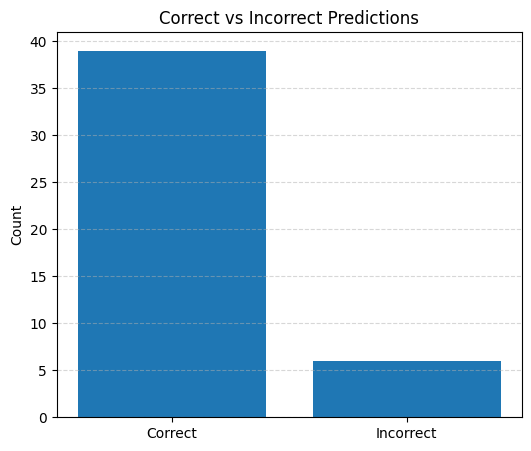

Correct: 39
Incorrect: 6


In [30]:
# JÓ-HIBÁS PREDIKCIÓ KIÉRTÉKELÉS

correct = 0
incorrect = 0

model.eval()

with torch.no_grad():
    for images, labels, _ in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)

        correct += (preds == labels).sum().item()
        incorrect += (preds != labels).sum().item()

# Adatok
values = [correct, incorrect]
labels = ["Correct", "Incorrect"]

# Diagram
plt.figure(figsize=(6, 5))
plt.bar(labels, values)
plt.title("Correct vs Incorrect Predictions")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print(f"Correct: {correct}")
print(f"Incorrect: {incorrect}")
